In [1]:
import pickle
from tempfile import mkdtemp
from shutil import rmtree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from feature_engine.preprocessing import MatchVariables
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.imputation import (
    AddMissingIndicator, MeanMedianImputer, CategoricalImputer, EndTailImputer
)
from feature_engine.transformation import PowerTransformer
from feature_engine.creation import RelativeFeatures
from feature_engine.selection import DropFeatures

In [2]:
%load_ext watermark

In [3]:
%watermark -vp sklearn,feature_engine

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

sklearn       : 1.0.2
feature_engine: 1.4.0



## Data

Con un muy pequeño EDA.

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df.shape

(710, 21)

In [6]:
df.sample(2)

,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20
217,0,A,0.571474,60.22515,0.835658,0.541887,0.405871,1.923620,0.257371,30.462956,...,18.791263,B,0,B,0.003372,0.504353,A,C,20112.378156,1.262238
138,1,A,0.355531,41.53850,0.336258,2.173741,0.251344,3.581506,0.751274,91.282100,...,16.808402,C,1,C,0.614067,1.157997,B,C,1160.542375,0.241815


In [7]:
df["target"].value_counts(normalize=True)

0    0.8
1    0.2
Name: target, dtype: float64

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  710 non-null    int64  
 1   v1      710 non-null    object 
 2   v2      710 non-null    float64
 3   v3      710 non-null    float64
 4   v4      710 non-null    float64
 5   v5      710 non-null    float64
 6   v6      710 non-null    float64
 7   v7      710 non-null    float64
 8   v8      710 non-null    float64
 9   v9      710 non-null    float64
 10  v10     680 non-null    float64
 11  v11     710 non-null    float64
 12  v12     710 non-null    object 
 13  v13     710 non-null    int64  
 14  v14     710 non-null    object 
 15  v15     710 non-null    float64
 16  v16     710 non-null    float64
 17  v17     630 non-null    object 
 18  v18     668 non-null    object 
 19  v19     686 non-null    float64
 20  v20     710 non-null    float64
dtypes: float64(14), int64(2), object(5)
mem

¿Hay missing values?

¿Qué pinta tienen las categóricas?

In [9]:
categorical_columns_ = [c for c in df.columns if df[c].dtype == 'O']
for c in categorical_columns_:
    print(c)
    print(df[c].value_counts(normalize=True, dropna=False), "\n")

v1
D    0.273239
A    0.269014
B    0.230986
C    0.226761
Name: v1, dtype: float64 

v12
B    0.440845
D    0.214085
C    0.191549
A    0.153521
Name: v12, dtype: float64 

v14
C    0.622535
B    0.201408
A    0.116901
D    0.059155
Name: v14, dtype: float64 

v17
A      0.495775
C      0.195775
B      0.195775
NaN    0.112676
Name: v17, dtype: float64 

v18
C      0.467606
B      0.215493
A      0.178873
D      0.078873
NaN    0.059155
Name: v18, dtype: float64 



In [10]:
df.groupby("v14")["target"].mean()

v14
A    0.156627
B    0.223776
C    0.196833
D    0.238095
Name: target, dtype: float64

### Split data

Separamos un set de test y lo descartamos durante el análisis.

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=33)

In [12]:
df_test.to_csv("data_test.csv", index=True)
del df_test

In [13]:
X = df_train.drop(["target"], axis=1)
y = df_train["target"]

In [14]:
categorical_columns = [c for c in X.columns if X[c].dtype == 'O']

discrete_columns = []
# discrete = [
#     c for c in X.columns if df[c].dtype != 'O' and len(X[c].unique()) < 20]

numerical_columns = [
    c for c in X.columns if X[c].dtype != 'O' and c not in discrete_columns]
# date_columns = ...

In [15]:
print(categorical_columns)
print(discrete_columns)
print(numerical_columns)

['v1', 'v12', 'v14', 'v17', 'v18']
[]
['v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v13', 'v15', 'v16', 'v19', 'v20']


## Pipeline

La ventaja de [`feature-engine`](https://feature-engine.readthedocs.io/en/latest/user_guide/index.html) es que nos permite aplicar las transformaciones a columnas específicas con más facilidad que `sklearn`. Además ofrece algunas transformaciones que no están disponibles en `sklearn`.

In [16]:
# NOTE se puede hacer mas prolijo encadenando pipelines!

pipe = Pipeline([

    # # Match input --------------------------------------------------------------
    # # ("drop_features", DropFeatures(features_to_drop=["v20"])),
    # # NOTE DropFeatures("col") hace que luego no podamos referenciar "col" 
    # #    en variables=numerical_columns, por ej. 
    # # ("match_variables", MatchVariables(missing_values="ignore")),
    # # NOTE MatchVariables() agrega la columna con np.nan si falta en test --> not good

    # Missing values -----------------------------------------------------------
    ('cat_imputer', CategoricalImputer(
        fill_value="Missing", return_object=True, variables=categorical_columns)),
    ('num_missing_ind', AddMissingIndicator(missing_only=True, variables=numerical_columns)),
    ('num_imputer', EndTailImputer(
        imputation_method='iqr', tail='right', fold=3, variables=numerical_columns)),

    # Categorical encoding -----------------------------------------------------
    ('cat_rare_labels', RareLabelEncoder(
        tol=50 / X.shape[0], n_categories=1, replace_with="Rare", variables=categorical_columns)),
    ('cat_encoder', OrdinalEncoder(
        encoding_method='ordered', errors="raise", variables=categorical_columns)),

    # Transformations ----------------------------------------------------------
    ('interactions', RelativeFeatures(
        variables=["v1", "v2", "v7"], reference=["v10", "v11"], func=["mul"])),
    ('polynomial', PowerTransformer(exp=2, variables=["v3", "v4", ])),
    # NOTE ver sklearn.preprocessing.PolynomialFeatures

    # Classifier ---------------------------------------------------------------
    ('clf', RandomForestClassifier(
        n_estimators=250, min_samples_leaf=5, max_features="sqrt", 
        oob_score=True, n_jobs=3, random_state=33))
])

# NOTE si vamos a usar GridSearchCV, podemos usar memory caching:
# cachedir = mkdtemp()
# pipe = Pipeline(steps, memory=cachedir)
# gcv.fit(X, y)
# rmtree(cachedir)

In [17]:
# # viz html
# set_config(display="diagram")
# pipe

In [18]:
set_config(display="text")

### Grid search

Hacemos una búsqueda sobre distintas configuraciones del pipeline. Los parámetros que elegimos y sus valores son solamente ilustrativos.

In [19]:
param_grid = [
    {
        'cat_rare_labels__tol': [i/X.shape[0] for i in [20, 50, 100]], #  NOTE tol exige fraccion
        'clf__min_samples_leaf': [5, 10, 20, 50, 100],
    },
    {
        'num_missing_ind': ["passthrough"],
        'num_imputer': [MeanMedianImputer(imputation_method='median', variables=numerical_columns)],
        'cat_encoder': [OneHotEncoder(variables=categorical_columns)],
        'interactions': ["passthrough"],
        'polynomial': ["passthrough"],
        # 'clf': [LogisticRegression(max_iter=1000)], # NOTE: no lo probamos porque estamos scoreando con OOB
    },
]


In [20]:
# NOTE hay que hacer esto porque sklearn.model_selection.GridSearchCV no se banca OOB!
# NOTE es complicado hacer random search de esta manera

results = []
for params in tqdm(ParameterGrid(param_grid)):
    pipe_ = clone(pipe) # NOTE para no ir pisando pipe original
    _ = pipe_.set_params(**params)
    _ = pipe_.fit(X, y)
    # NOTE only way to get oob predictions:
    y_pred = pipe_.named_steps['clf'].oob_decision_function_[:, 1] 
    auroc = roc_auc_score(y, y_pred)
    results.append({'params': params, 'auroc': auroc})

100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


In [21]:
df_results = pd.DataFrame(results)
df_results = pd.concat(
    [df_results, pd.json_normalize(df_results['params'])], axis=1)

In [22]:
df_results.sort_values("auroc", ascending=False)

,params,auroc,cat_rare_labels__tol,clf__min_samples_leaf,cat_encoder,interactions,num_imputer,num_missing_ind,polynomial
10,"{'cat_rare_labels__tol': 0.176056338028169, 'c...",0.968828,0.176056,5.0,NaN,NaN,NaN,NaN,NaN
5,"{'cat_rare_labels__tol': 0.0880281690140845, '...",0.968292,0.088028,5.0,NaN,NaN,NaN,NaN,NaN
0,"{'cat_rare_labels__tol': 0.035211267605633804,...",0.967848,0.035211,5.0,NaN,NaN,NaN,NaN,NaN
15,"{'cat_encoder': OneHotEncoder(variables=['v1',...",0.966535,NaN,NaN,"OneHotEncoder(variables=['v1', 'v12', 'v14', '...",passthrough,"MeanMedianImputer(variables=['v2', 'v3', 'v4',...",passthrough,passthrough
1,"{'cat_rare_labels__tol': 0.035211267605633804,...",0.960120,0.035211,10.0,NaN,NaN,NaN,NaN,NaN
6,"{'cat_rare_labels__tol': 0.0880281690140845, '...",0.959140,0.088028,10.0,NaN,NaN,NaN,NaN,NaN
11,"{'cat_rare_labels__tol': 0.176056338028169, 'c...",0.959140,0.176056,10.0,NaN,NaN,NaN,NaN,NaN
7,"{'cat_rare_labels__tol': 0.0880281690140845, '...",0.945310,0.088028,20.0,NaN,NaN,NaN,NaN,NaN
12,"{'cat_rare_labels__tol': 0.176056338028169, 'c...",0.945070,0.176056,20.0,NaN,NaN,NaN,NaN,NaN
2,"{'cat_rare_labels__tol': 0.035211267605633804,...",0.944367,0.035211,20.0,NaN,NaN,NaN,NaN,NaN


In [23]:
baseline_auroc = df_results.query("interactions == 'passthrough'")['auroc'].iloc[0]

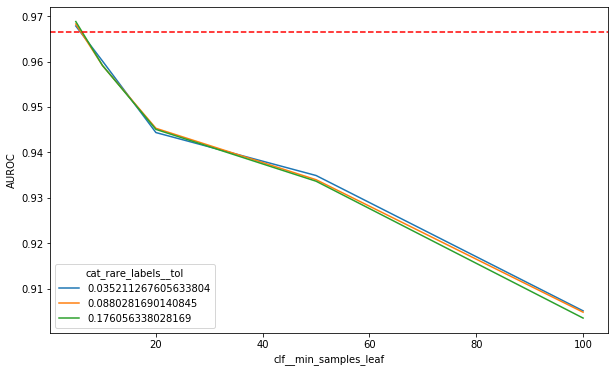

In [24]:
# plot auroc by min_samples_leaf with one curve by rare label tol
df_plot = df_results.pivot_table(
    index="clf__min_samples_leaf", columns="cat_rare_labels__tol", values="auroc")
df_plot.plot(kind="line", figsize=(10, 6))
plt.axhline(y=baseline_auroc, color="red", linestyle="--")
plt.ylabel("AUROC")
plt.show()

### Feature importance

In [25]:
best_params = df_results.loc[df_results["auroc"].idxmax()]["params"]
best_pipe = clone(pipe)
_ = best_pipe.set_params(**best_params)
_ = best_pipe.fit(X, y)

In [26]:
# feature importance
importances = best_pipe.named_steps['clf'].feature_importances_
# get feature names
feature_names = best_pipe[-2].get_feature_names_out() # anteultimo paso
# # NOTE equivalent to:
# X_transformed = best_pipe[:-1].transform(X)
# X_transformed.columns

df_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_importance.sort_values("importance", ascending=False)

,feature,importance
14,v15,0.175943
8,v9,0.157502
15,v16,0.141709
7,v8,0.088230
4,v5,0.056360
12,v13,0.044610
11,v12,0.043233
16,v17,0.029092
5,v6,0.025352
2,v3,0.021382


**Una buena idea** es correr un RandomForest baseline al comienzo del análisis y analizar el _feature importance_.

Si:

1. vemos que algunas variables tienen un valor de importancia demasiado abajo, 
2. nuestra intuición/conocimiento del dominio nos dice que probablemente sean irrelevantes para la predicción, y
3. vemos que al eliminar las variables la performance del baseline no se deteriora 

podemos eliminar esas variables al comienzo. De esta manera, las corridas subsiguientes del modelo pueden llegar a ser mucho más eficientes.

### Save pipeline

In [27]:
# save best pipeline as pickle
with open("best_pipe.pkl", "wb") as f:
    pickle.dump(best_pipe, f)

---------------------------